#Setup

In [1]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install "stable-baselines3[extra]>=2.0.0a4"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.12).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from stable_baselines3.common.env_checker import check_env


#Environment

In [3]:
def seasonal_duck_curve(hour, season, noise_scale=0.03):
    """ Computes electricity demand based on seasonal duck curve """
    A = 400
    seasonal_params = {
        1: (100, 7, 80, 12, 120, 14, 250, 18, 30, 4),  # Summer
        2: (180, 6, 40, 12, 80, 14, 220, 17, 60, 4),  # Winter
        3: (130, 7, 90, 12, 100, 14, 180, 18, 40, 4)  # Spring/Autumn
    }
    B, t_morning, C, t_dip, D, mu_dip, E, t_evening, F, t_early = seasonal_params[season]
    demand = A + B / (1 + np.exp(-1 * (hour - t_morning))) - C / (1 + np.exp(-1 * (hour - t_dip))) - D * np.exp(-((hour - mu_dip)**2) / 4) + E / (1 + np.exp(-1 * (hour - t_evening)))
    return demand * random.uniform(0.9, 1.1)

def electricity_price_function(hour, season, demand, noise_scale=0.03):
    """ Computes electricity price based on seasonal demand """
    season_params = {
        1: (30, 15, 10),  # Summer
        2: (28, 14, 9),   # Winter
        3: (25, 12, 8)    # Spring/Autumn
    }
    A_q, B_q, C_q = season_params[season]
    base_price = A_q + B_q * np.cos(2 * np.pi * hour / 24) + C_q * np.cos(4 * np.pi * hour / 24)
    return max(base_price * random.uniform(0.9, 1.1), 0)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import random

class ElectricityMarketEnv(gym.Env):
    """
    Custom Gym environment for an electricity market with battery storage.
    The agent decides when to charge/discharge to maximize profit.
    """
    def __init__(self, max_timesteps=365, degradation_rate=0.99):
        super(ElectricityMarketEnv, self).__init__()
        self.timestep = 0
        self.max_timesteps = max_timesteps
        self.season = self.get_season_from_timestep(0)  # Set initial season based on real months
        self.episode_count = 0  # Track training episodes
        self.degradation_rate = degradation_rate  # Battery degradation factor

        # Battery parameters
        self.initial_battery_capacity = 100  # Initial max storage capacity
        self.battery_capacity = self.initial_battery_capacity  # Maximum storage capacity
        self.battery_soc = 50  # Initial state of charge (SoC)
        self.efficiency = 0.95  # Charging/discharging efficiency

        # Electricity market parameters
        self.base_min_price, self.base_max_price = self._calculate_price_bounds()
        self.base_min_demand, self.base_max_demand = self._calculate_demand_bounds()

        self.min_price, self.max_price = self.base_min_price * 0.9, self.base_max_price * 1.1
        self.min_demand, self.max_demand = self.base_min_demand * 0.9, self.base_max_demand * 1.1


        # Action space: Charge (+) or discharge (-) within battery capacity
        self.action_space = spaces.Box(low=-self.battery_capacity, high=self.battery_capacity, shape=(1,), dtype=np.float32)

        # Observation space: [Battery SoC, Battery Capacity, Electricity Price, Demand, Hour, Season]
        self.observation_space = spaces.Box(
            low=np.array([0, 50, self.min_price, self.min_demand, 0, 1], dtype=np.float32),
            high=np.array([self.initial_battery_capacity, self.initial_battery_capacity, self.max_price, self.max_demand, 23, 3], dtype=np.float32),
            dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.battery_capacity = self.initial_battery_capacity  # Reset battery capacity
        self.timestep = 0
        self.battery_soc = 50  # Reset battery SoC
        self.season = self.get_season_from_timestep(self.timestep)  # Set season dynamically
        self.episode_count += 1  # Track episode count
        return self._get_state(), {}

    def step(self, action):
        """
        Executes one step in the environment.
        Action: Charge (>0) or discharge (<0) electricity.
        """
        self.timestep += 1
        self.season = self.get_season_from_timestep(self.timestep)
        done = self.timestep >= self.max_timesteps or self.battery_soc <= 0

        self.battery_capacity *= self.degradation_rate
        self.battery_capacity = max(self.battery_capacity, 50)  # Minimum capacity limit

        # Get new price and demand based on season
        hour = self.timestep % 24
        demand = seasonal_duck_curve(hour, self.season)
        price = electricity_price_function(hour, self.season, demand)

        # Clip action to valid range (-battery_capacity, +battery_capacity)
        action = np.clip(action[0], -self.battery_capacity, self.battery_capacity)

        # Charge/discharge the battery
        if action > 0:  # Charging (cost money)
            charge_amount = min(action, self.battery_capacity - self.battery_soc)
            cost = charge_amount * price / self.efficiency
            self.battery_soc += charge_amount * self.efficiency
            reward = -cost  # Negative reward for spending money
            #print(f"Step {self.timestep}, Season: {self.get_season_name(self.season)}: Charging {charge_amount:.2f} units at price {price:.2f}. Cost: {cost:.2f}. SoC: {self.battery_soc:.2f}.")
        else:  # Discharging (sell to market)
            discharge_amount = min(-action, self.battery_soc, demand)
            revenue = discharge_amount * price * self.efficiency
            self.battery_soc -= discharge_amount / self.efficiency
            reward = revenue  # Positive reward for selling
            #print(f"Step {self.timestep}, Season: {self.get_season_name(self.season)}: Discharging {discharge_amount:.2f} units at price {price:.2f}. Revenue: {revenue:.2f}. SoC: {self.battery_soc:.2f}.")

        next_state = np.array([self.battery_soc, self.battery_capacity, price, demand, hour, self.season], dtype=np.float32)
        return next_state, reward, done, False, {}

    def _get_state(self):
        """ Returns the current state: [SoC, Price, Demand, Hour, Season] """
        hour = self.timestep % 24
        demand = seasonal_duck_curve(hour, self.season)
        price = electricity_price_function(hour, self.season, demand)
        #print(f"State - SoC: {self.battery_soc:.2f}, Price: {price:.2f}, Demand: {demand:.2f}, Hour: {hour}, Season: {self.season}.")
        return np.array([self.battery_soc, self.battery_capacity, price, demand, hour, self.season], dtype=np.float32)



    def get_season_from_timestep(self, timestep):
        """ Determines season based on day of the year """
        month = (timestep // 30) % 12  # Approximate month from timestep
        if month in [11, 0, 1]:
            return 2  # Winter
        elif month in [5, 6, 7]:
            return 1  # Summer
        else:
            return 3  # Spring/Autumn

    def get_season_name(self, season):
        return {1: "Summer", 2: "Winter", 3: "Spring/Autumn"}.get(season, "Unknown")


    def evaluate_agent(self, agent, num_episodes=3):
        """ Evaluates the agent over multiple episodes and prints performance metrics per season. """
        total_rewards = []
        season_rewards = {1: [], 2: [], 3: []}

        for ep in range(num_episodes):
            state, _ = self.reset()
            done = False
            episode_reward = 0
            seasonal_reward = {1: 0, 2: 0, 3: 0}

            while not done:
                action, _ = agent.predict(state)
                state, reward, done, _, _ = self.step(action)
                episode_reward += reward
                seasonal_reward[self.season] += reward

            total_rewards.append(episode_reward)
            for season in seasonal_reward:
                season_rewards[season].append(seasonal_reward[season])


        avg_reward = np.mean(total_rewards)
        avg_seasonal_rewards = {season: np.mean(rewards) if rewards else 0 for season, rewards in season_rewards.items()}

        print(f"\nEvaluation Results:")
        print(f"Average Reward over {num_episodes} episodes: {avg_reward:.2f}")
        print(f"Seasonal Performance:")
        for season, avg in avg_seasonal_rewards.items():
            print(f"  {self.get_season_name(season)}: {avg:.2f}")

        return avg_reward, avg_seasonal_rewards

    def _calculate_price_bounds(self):
        """ Determine min/max price dynamically based on electricity_price_function """
        min_price = float('inf')
        max_price = float('-inf')
        for season in [1, 2, 3]:
            for hour in range(24):
                demand = seasonal_duck_curve(hour, season)
                price = electricity_price_function(hour, season, demand)
                min_price = min(min_price, price)
                max_price = max(max_price, price)
        return min_price, max_price

    def _calculate_demand_bounds(self):
        """ Determine min/max demand dynamically based on seasonal_duck_curve """
        min_demand = float('inf')
        max_demand = float('-inf')
        for season in [1, 2, 3]:
            for hour in range(24):
                demand = seasonal_duck_curve(hour, season)
                min_demand = min(min_demand, demand)
                max_demand = max(max_demand, demand)
        return min_demand, max_demand



In [18]:
env = ElectricityMarketEnv()
obs, _ = env.reset()



#Evaluation Functions


In [6]:
from stable_baselines3.common.evaluation import evaluate_policy


In [7]:
%pip install tensorboard
%load_ext tensorboard


In [8]:
import time
import numpy as np
import tensorflow as tf
from stable_baselines3.common.callbacks import BaseCallback

class RLComparisonCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RLComparisonCallback, self).__init__(verbose)
        self.start_time = time.time()

    def _on_training_start(self) -> None:
        self.episode_rewards = []
        self.episode_lengths = []
        self.total_timesteps = 0

    def _on_step(self) -> bool:
        if self.locals.get("dones") is not None:
            for done, reward, info in zip(self.locals["dones"], self.locals["rewards"], self.locals["infos"]):
                if done:
                    episode_reward = info.get("episode", {}).get("r", reward)
                    episode_length = info.get("episode", {}).get("l", 0)

                    self.episode_rewards.append(episode_reward)
                    self.episode_lengths.append(episode_length)
                    self.total_timesteps += episode_length

                    # Logging metrics after each episode using log scale
                    avg_reward = np.mean(self.episode_rewards[-100:])
                    cum_reward = np.sum(self.episode_rewards)
                    discounted_reward = np.sum([r * (0.99 ** i) for i, r in enumerate(self.episode_rewards)])
                    convergence_rate = np.std(self.episode_rewards[-100:])
                    sample_efficiency = cum_reward / max(1, self.total_timesteps)
                    stability = np.std(self.episode_rewards)
                    policy_entropy = info.get('entropy', 0)
                    time_complexity = time.time() - self.start_time
                    space_complexity = self.model.policy.parameters_to_vector().nbytes

                    self.logger.record("custom/average_reward", avg_reward)
                    self.logger.record("custom/cumulative_reward", cum_reward)
                    self.logger.record("custom/discounted_reward", discounted_reward)
                    self.logger.record("custom/convergence_rate", convergence_rate)
                    self.logger.record("custom/sample_efficiency", sample_efficiency)
                    self.logger.record("custom/stability", stability)
                    self.logger.record("custom/policy_entropy", policy_entropy)
                    self.logger.record("custom/time_complexity", time_complexity)
                    self.logger.record("custom/space_complexity", space_complexity)

        return True


#Lets start with training

In [9]:
from stable_baselines3 import PPO, A2C, SAC, TD3, DDPG

In [10]:
from stable_baselines3.common.callbacks import CheckpointCallback, CallbackList

#A2C diffrent implemetanions with diffrent advaatage functions

In [11]:
import warnings
from abc import ABC, abstractmethod
from collections.abc import Generator
from typing import Any, Optional, Union

import numpy as np
import torch as th
from gymnasium import spaces

from stable_baselines3.common.preprocessing import get_action_dim, get_obs_shape
from stable_baselines3.common.type_aliases import (
    DictReplayBufferSamples,
    DictRolloutBufferSamples,
    ReplayBufferSamples,
    RolloutBufferSamples,
)
from stable_baselines3.common.utils import get_device
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.buffers import BaseBuffer
from stable_baselines3.common.vec_env import VecNormalize

try:
    # Check memory used by replay buffer when possible
    import psutil
except ImportError:
    psutil = None

In [12]:
class RolloutBufferMonteCArlo(BaseBuffer):
    """
    Rollout buffer used in on-policy algorithms like A2C/PPO.
    It corresponds to ``buffer_size`` transitions collected
    using the current policy.
    This experience will be discarded after the policy update.
    In order to use PPO objective, we also store the current value of each state
    and the log probability of each taken action.

    The term rollout here refers to the model-free notion and should not
    be used with the concept of rollout used in model-based RL or planning.
    Hence, it is only involved in policy and value function training but not action selection.

    :param buffer_size: Max number of element in the buffer
    :param observation_space: Observation space
    :param action_space: Action space
    :param device: PyTorch device
    :param gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator
        Equivalent to classic advantage when set to 1.
    :param gamma: Discount factor
    :param n_envs: Number of parallel environments
    """

    observations: np.ndarray
    actions: np.ndarray
    rewards: np.ndarray
    advantages: np.ndarray
    returns: np.ndarray
    episode_starts: np.ndarray
    log_probs: np.ndarray
    values: np.ndarray

    def __init__(
        self,
        buffer_size: int,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        device: Union[th.device, str] = "auto",
        gae_lambda: float = 1,
        gamma: float = 0.99,
        n_envs: int = 1,
    ):
        super().__init__(buffer_size, observation_space, action_space, device, n_envs=n_envs)
        self.gae_lambda = gae_lambda
        self.gamma = gamma
        self.generator_ready = False
        self.reset()

    def reset(self) -> None:
        self.observations = np.zeros((self.buffer_size, self.n_envs, *self.obs_shape), dtype=np.float32)
        self.actions = np.zeros((self.buffer_size, self.n_envs, self.action_dim), dtype=np.float32)
        self.rewards = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.returns = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.episode_starts = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.values = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.log_probs = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.advantages = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.generator_ready = False
        super().reset()
  #####CHANGED HERE
    def compute_returns_and_advantage(self, last_values: th.Tensor, dones: np.ndarray) -> None:
        last_values = last_values.clone().cpu().numpy().flatten()
        for step in reversed(range(self.buffer_size)):
            if step == self.buffer_size - 1:
                next_non_terminal = 1.0 - dones.astype(np.float32)
                next_values = last_values
            else:
                next_non_terminal = 1.0 - self.episode_starts[step + 1]
                next_values = self.values[step + 1]
            return_t = self.rewards[step] + self.gamma * next_values * next_non_terminal
            self.advantages[step] = return_t - self.values[step]
        self.returns = self.advantages + self.values
################

    def add(
        self,
        obs: np.ndarray,
        action: np.ndarray,
        reward: np.ndarray,
        episode_start: np.ndarray,
        value: th.Tensor,
        log_prob: th.Tensor,
    ) -> None:
        """
        :param obs: Observation
        :param action: Action
        :param reward:
        :param episode_start: Start of episode signal.
        :param value: estimated value of the current state
            following the current policy.
        :param log_prob: log probability of the action
            following the current policy.
        """
        if len(log_prob.shape) == 0:
            # Reshape 0-d tensor to avoid error
            log_prob = log_prob.reshape(-1, 1)

        # Reshape needed when using multiple envs with discrete observations
        # as numpy cannot broadcast (n_discrete,) to (n_discrete, 1)
        if isinstance(self.observation_space, spaces.Discrete):
            obs = obs.reshape((self.n_envs, *self.obs_shape))

        # Reshape to handle multi-dim and discrete action spaces, see GH #970 #1392
        action = action.reshape((self.n_envs, self.action_dim))

        self.observations[self.pos] = np.array(obs)
        self.actions[self.pos] = np.array(action)
        self.rewards[self.pos] = np.array(reward)
        self.episode_starts[self.pos] = np.array(episode_start)
        self.values[self.pos] = value.clone().cpu().numpy().flatten()
        self.log_probs[self.pos] = log_prob.clone().cpu().numpy()
        self.pos += 1
        if self.pos == self.buffer_size:
            self.full = True

    def get(self, batch_size: Optional[int] = None) -> Generator[RolloutBufferSamples, None, None]:
        assert self.full, ""
        indices = np.random.permutation(self.buffer_size * self.n_envs)
        # Prepare the data
        if not self.generator_ready:
            _tensor_names = [
                "observations",
                "actions",
                "values",
                "log_probs",
                "advantages",
                "returns",
            ]

            for tensor in _tensor_names:
                self.__dict__[tensor] = self.swap_and_flatten(self.__dict__[tensor])
            self.generator_ready = True

        # Return everything, don't create minibatches
        if batch_size is None:
            batch_size = self.buffer_size * self.n_envs

        start_idx = 0
        while start_idx < self.buffer_size * self.n_envs:
            yield self._get_samples(indices[start_idx : start_idx + batch_size])
            start_idx += batch_size

    def _get_samples(
        self,
        batch_inds: np.ndarray,
        env: Optional[VecNormalize] = None,
    ) -> RolloutBufferSamples:
        data = (
            self.observations[batch_inds],
            self.actions[batch_inds],
            self.values[batch_inds].flatten(),
            self.log_probs[batch_inds].flatten(),
            self.advantages[batch_inds].flatten(),
            self.returns[batch_inds].flatten(),
        )
        return RolloutBufferSamples(*tuple(map(self.to_torch, data)))

In [13]:
class RolloutBufferbootstrapping(BaseBuffer):
    """
    Rollout buffer used in on-policy algorithms like A2C/PPO.
    It corresponds to ``buffer_size`` transitions collected
    using the current policy.
    This experience will be discarded after the policy update.
    In order to use PPO objective, we also store the current value of each state
    and the log probability of each taken action.

    The term rollout here refers to the model-free notion and should not
    be used with the concept of rollout used in model-based RL or planning.
    Hence, it is only involved in policy and value function training but not action selection.

    :param buffer_size: Max number of element in the buffer
    :param observation_space: Observation space
    :param action_space: Action space
    :param device: PyTorch device
    :param gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator
        Equivalent to classic advantage when set to 1.
    :param gamma: Discount factor
    :param n_envs: Number of parallel environments
    """

    observations: np.ndarray
    actions: np.ndarray
    rewards: np.ndarray
    advantages: np.ndarray
    returns: np.ndarray
    episode_starts: np.ndarray
    log_probs: np.ndarray
    values: np.ndarray

    def __init__(
        self,
        buffer_size: int,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        device: Union[th.device, str] = "auto",
        gae_lambda: float = 1,
        gamma: float = 0.99,
        n_envs: int = 1,
    ):
        super().__init__(buffer_size, observation_space, action_space, device, n_envs=n_envs)
        self.gae_lambda = gae_lambda
        self.gamma = gamma
        self.generator_ready = False
        self.reset()

    def reset(self) -> None:
        self.observations = np.zeros((self.buffer_size, self.n_envs, *self.obs_shape), dtype=np.float32)
        self.actions = np.zeros((self.buffer_size, self.n_envs, self.action_dim), dtype=np.float32)
        self.rewards = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.returns = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.episode_starts = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.values = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.log_probs = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.advantages = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.generator_ready = False
        super().reset()
  #####CHANGED HERE
    def compute_returns_and_advantage(self, last_values: th.Tensor, dones: np.ndarray) -> None:
        last_values = last_values.clone().cpu().numpy().flatten()
        for step in reversed(range(self.buffer_size)):
            if step == self.buffer_size - 1:
                next_non_terminal = 1.0 - dones.astype(np.float32)
                next_values = last_values
            else:
                next_non_terminal = 1.0 - self.episode_starts[step + 1]
                next_values = self.values[step + 1]
            # Bootstrapping with multiple heads (simplified)
            bootstrapped_value = np.mean([self.rewards[step], self.gamma * next_values * next_non_terminal])
            self.advantages[step] = bootstrapped_value - self.values[step]
        self.returns = self.advantages + self.values
################

    def add(
        self,
        obs: np.ndarray,
        action: np.ndarray,
        reward: np.ndarray,
        episode_start: np.ndarray,
        value: th.Tensor,
        log_prob: th.Tensor,
    ) -> None:
        """
        :param obs: Observation
        :param action: Action
        :param reward:
        :param episode_start: Start of episode signal.
        :param value: estimated value of the current state
            following the current policy.
        :param log_prob: log probability of the action
            following the current policy.
        """
        if len(log_prob.shape) == 0:
            # Reshape 0-d tensor to avoid error
            log_prob = log_prob.reshape(-1, 1)

        # Reshape needed when using multiple envs with discrete observations
        # as numpy cannot broadcast (n_discrete,) to (n_discrete, 1)
        if isinstance(self.observation_space, spaces.Discrete):
            obs = obs.reshape((self.n_envs, *self.obs_shape))

        # Reshape to handle multi-dim and discrete action spaces, see GH #970 #1392
        action = action.reshape((self.n_envs, self.action_dim))

        self.observations[self.pos] = np.array(obs)
        self.actions[self.pos] = np.array(action)
        self.rewards[self.pos] = np.array(reward)
        self.episode_starts[self.pos] = np.array(episode_start)
        self.values[self.pos] = value.clone().cpu().numpy().flatten()
        self.log_probs[self.pos] = log_prob.clone().cpu().numpy()
        self.pos += 1
        if self.pos == self.buffer_size:
            self.full = True

    def get(self, batch_size: Optional[int] = None) -> Generator[RolloutBufferSamples, None, None]:
        assert self.full, ""
        indices = np.random.permutation(self.buffer_size * self.n_envs)
        # Prepare the data
        if not self.generator_ready:
            _tensor_names = [
                "observations",
                "actions",
                "values",
                "log_probs",
                "advantages",
                "returns",
            ]

            for tensor in _tensor_names:
                self.__dict__[tensor] = self.swap_and_flatten(self.__dict__[tensor])
            self.generator_ready = True

        # Return everything, don't create minibatches
        if batch_size is None:
            batch_size = self.buffer_size * self.n_envs

        start_idx = 0
        while start_idx < self.buffer_size * self.n_envs:
            yield self._get_samples(indices[start_idx : start_idx + batch_size])
            start_idx += batch_size

    def _get_samples(
        self,
        batch_inds: np.ndarray,
        env: Optional[VecNormalize] = None,
    ) -> RolloutBufferSamples:
        data = (
            self.observations[batch_inds],
            self.actions[batch_inds],
            self.values[batch_inds].flatten(),
            self.log_probs[batch_inds].flatten(),
            self.advantages[batch_inds].flatten(),
            self.returns[batch_inds].flatten(),
        )
        return RolloutBufferSamples(*tuple(map(self.to_torch, data)))

In [14]:
class RolloutBufferAggregated(BaseBuffer):
    """
    Rollout buffer used in on-policy algorithms like A2C/PPO.
    It corresponds to ``buffer_size`` transitions collected
    using the current policy.
    This experience will be discarded after the policy update.
    In order to use PPO objective, we also store the current value of each state
    and the log probability of each taken action.

    The term rollout here refers to the model-free notion and should not
    be used with the concept of rollout used in model-based RL or planning.
    Hence, it is only involved in policy and value function training but not action selection.

    :param buffer_size: Max number of element in the buffer
    :param observation_space: Observation space
    :param action_space: Action space
    :param device: PyTorch device
    :param gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator
        Equivalent to classic advantage when set to 1.
    :param gamma: Discount factor
    :param n_envs: Number of parallel environments
    """

    observations: np.ndarray
    actions: np.ndarray
    rewards: np.ndarray
    advantages: np.ndarray
    returns: np.ndarray
    episode_starts: np.ndarray
    log_probs: np.ndarray
    values: np.ndarray

    def __init__(
        self,
        buffer_size: int,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        device: Union[th.device, str] = "auto",
        gae_lambda: float = 1,
        gamma: float = 0.99,
        n_envs: int = 1,
    ):
        super().__init__(buffer_size, observation_space, action_space, device, n_envs=n_envs)
        self.gae_lambda = gae_lambda
        self.gamma = gamma
        self.generator_ready = False
        self.reset()

    def reset(self) -> None:
        self.observations = np.zeros((self.buffer_size, self.n_envs, *self.obs_shape), dtype=np.float32)
        self.actions = np.zeros((self.buffer_size, self.n_envs, self.action_dim), dtype=np.float32)
        self.rewards = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.returns = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.episode_starts = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.values = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.log_probs = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.advantages = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.generator_ready = False
        super().reset()
  #####CHANGED HERE
    def compute_returns_and_advantage(self, last_values: th.Tensor, dones: np.ndarray) -> None:
        # Aggregation weights
        self.td_lambda_weight = 0.25
        self.mc_weight = 0.25
        self.gae_weight = 0.5

        last_values = last_values.clone().cpu().numpy().flatten()

        # Loop through the buffer in reverse order to calculate advantages and returns
        for step in reversed(range(self.buffer_size)):
            if step == self.buffer_size - 1:
                next_non_terminal = 1.0 - dones.astype(np.float32)
                next_values = last_values
            else:
                next_non_terminal = 1.0 - self.episode_starts[step + 1]
                next_values = self.values[step + 1]

            # 1. TD Advantage
            td_advantage = self.rewards[step] + self.gamma * next_values * next_non_terminal - self.values[step]

            # 2. Monte Carlo Advantage (reward-to-go)
            mc_advantage = np.sum(self.rewards[step:] * (self.gamma ** np.arange(len(self.rewards[step:]))))

            # 3. GAE Advantage (Generalized Advantage Estimation)
            gae_advantage = 0
            gae_discount = 1.0
            for t in reversed(range(step, self.buffer_size - 1)):  # Fix the index to avoid going out of bounds
                delta = self.rewards[t] + self.gamma * self.values[t + 1] * (1.0 - self.episode_starts[t + 1]) - self.values[t]
                gae_advantage = delta + self.gae_lambda * gae_discount * gae_advantage
                gae_discount *= self.gamma * self.gae_lambda

            # Aggregate all advantages using the specified weights
            aggregated_advantage = (
                self.td_lambda_weight * td_advantage +
                self.mc_weight * mc_advantage +
                self.gae_weight * gae_advantage
            )

            # Store the aggregated advantage in the buffer
            self.advantages[step] = aggregated_advantage

        # Compute the returns by summing advantages and values
        self.returns = self.advantages + self.values

################

    def add(
        self,
        obs: np.ndarray,
        action: np.ndarray,
        reward: np.ndarray,
        episode_start: np.ndarray,
        value: th.Tensor,
        log_prob: th.Tensor,
    ) -> None:
        """
        :param obs: Observation
        :param action: Action
        :param reward:
        :param episode_start: Start of episode signal.
        :param value: estimated value of the current state
            following the current policy.
        :param log_prob: log probability of the action
            following the current policy.
        """
        if len(log_prob.shape) == 0:
            # Reshape 0-d tensor to avoid error
            log_prob = log_prob.reshape(-1, 1)

        # Reshape needed when using multiple envs with discrete observations
        # as numpy cannot broadcast (n_discrete,) to (n_discrete, 1)
        if isinstance(self.observation_space, spaces.Discrete):
            obs = obs.reshape((self.n_envs, *self.obs_shape))

        # Reshape to handle multi-dim and discrete action spaces, see GH #970 #1392
        action = action.reshape((self.n_envs, self.action_dim))

        self.observations[self.pos] = np.array(obs)
        self.actions[self.pos] = np.array(action)
        self.rewards[self.pos] = np.array(reward)
        self.episode_starts[self.pos] = np.array(episode_start)
        self.values[self.pos] = value.clone().cpu().numpy().flatten()
        self.log_probs[self.pos] = log_prob.clone().cpu().numpy()
        self.pos += 1
        if self.pos == self.buffer_size:
            self.full = True

    def get(self, batch_size: Optional[int] = None) -> Generator[RolloutBufferSamples, None, None]:
        assert self.full, ""
        indices = np.random.permutation(self.buffer_size * self.n_envs)
        # Prepare the data
        if not self.generator_ready:
            _tensor_names = [
                "observations",
                "actions",
                "values",
                "log_probs",
                "advantages",
                "returns",
            ]

            for tensor in _tensor_names:
                self.__dict__[tensor] = self.swap_and_flatten(self.__dict__[tensor])
            self.generator_ready = True

        # Return everything, don't create minibatches
        if batch_size is None:
            batch_size = self.buffer_size * self.n_envs

        start_idx = 0
        while start_idx < self.buffer_size * self.n_envs:
            yield self._get_samples(indices[start_idx : start_idx + batch_size])
            start_idx += batch_size

    def _get_samples(
        self,
        batch_inds: np.ndarray,
        env: Optional[VecNormalize] = None,
    ) -> RolloutBufferSamples:
        data = (
            self.observations[batch_inds],
            self.actions[batch_inds],
            self.values[batch_inds].flatten(),
            self.log_probs[batch_inds].flatten(),
            self.advantages[batch_inds].flatten(),
            self.returns[batch_inds].flatten(),
        )
        return RolloutBufferSamples(*tuple(map(self.to_torch, data)))

In [15]:
from stable_baselines3 import A2C

# Run algorithm with diffrent advantage mehods

In [45]:
SEEDS = [79, 90, 34, 68]
steps = 1000000

In [46]:
classes = { "aggregated": RolloutBufferAggregated, "GAE": None, "Monte Carlo": RolloutBufferMonteCArlo , "bootstrapping": RolloutBufferbootstrapping,}

In [47]:
from sys import implementation
model_type = "A2C"
for seed in SEEDS:
  for advantage_method, imple in classes.items():
    env.reset(seed=seed)
    print(f"{model_type}_{seed}_{steps}_{advantage_method}")
    checkpoint_callback = CheckpointCallback(
        save_freq=100000,  # Save every 100,000 steps
        save_path='./models_a2c_advantage_types/',  # Directory to save the model
        name_prefix=f"{model_type}_{seed}_{steps}_{advantage_method}"  # Prefix for the saved model files
    )
    callback = CallbackList([RLComparisonCallback(), checkpoint_callback])
    if imple is not None:
      model = A2C("MlpPolicy", env, verbose=0, tensorboard_log="./tensorboard/",  seed=seed, rollout_buffer_class=imple).learn(steps, callback=callback, tb_log_name=f"{model_type}_{seed}_{steps}_{advantage_method}")
    else:
      model = A2C("MlpPolicy", env, verbose=0, tensorboard_log="./tensorboard/",  seed=seed).learn(steps, callback=callback, tb_log_name=f"{model_type}_{seed}_{steps}_{advantage_method}")
    model.save(f"./models_a2c_advantage_types/{model_type}_{seed}_{steps}_{advantage_method}")
    print(f"{model_type}_{seed}_{steps}_{advantage_method}")
    reward, _ = env.evaluate_agent(model, num_episodes=365)

A2C_79_100000_aggregated
A2C_79_100000_aggregated

Evaluation Results:
Average Reward over 365 episodes: 1603.51
Seasonal Performance:
  Summer: 0.00
  Winter: 1603.51
  Spring/Autumn: 0.00
A2C_79_100000_GAE
A2C_79_100000_GAE

Evaluation Results:
Average Reward over 365 episodes: 1591.99
Seasonal Performance:
  Summer: 0.00
  Winter: 1591.99
  Spring/Autumn: 0.00
A2C_79_100000_Monte Carlo
A2C_79_100000_Monte Carlo

Evaluation Results:
Average Reward over 365 episodes: 2048.12
Seasonal Performance:
  Summer: 0.00
  Winter: 2048.12
  Spring/Autumn: 0.00
A2C_79_100000_bootstrapping
A2C_79_100000_bootstrapping

Evaluation Results:
Average Reward over 365 episodes: 2132.34
Seasonal Performance:
  Summer: 0.00
  Winter: 2132.34
  Spring/Autumn: 0.00


'''
A2C_34_100000_aggregated
A2C_34_100000_aggregated

Evaluation Results:
Average Reward over 365 episodes: 1849.35
Seasonal Performance:
  Summer: 0.00
  Winter: 1849.35
  Spring/Autumn: 0.00
A2C_34_100000_GAE
A2C_34_100000_GAE

Evaluation Results:
Average Reward over 365 episodes: 1984.18
Seasonal Performance:
  Summer: 0.00
  Winter: 1984.18
  Spring/Autumn: 0.00
A2C_34_100000_Monte Carlo
A2C_34_100000_Monte Carlo

Evaluation Results:
Average Reward over 365 episodes: 2118.43
Seasonal Performance:
  Summer: 0.00
  Winter: 2118.43
  Spring/Autumn: 0.00
A2C_34_100000_bootstrapping
A2C_34_100000_bootstrapping

Evaluation Results:
Average Reward over 365 episodes: 2183.75
Seasonal Performance:
  Summer: 0.00
  Winter: 2183.75
  Spring/Autumn: 0.00
A2C_90_100000_aggregated
A2C_90_100000_aggregated

Evaluation Results:
Average Reward over 365 episodes: 2100.09
Seasonal Performance:
  Summer: 0.00
  Winter: 2100.09
  Spring/Autumn: 0.00
A2C_90_100000_GAE
A2C_90_100000_GAE

Evaluation Results:
Average Reward over 365 episodes: 2127.70
Seasonal Performance:
  Summer: 0.00
  Winter: 2127.70
  Spring/Autumn: 0.00
A2C_90_100000_Monte Carlo
A2C_90_100000_Monte Carlo

Evaluation Results:
Average Reward over 365 episodes: 2144.97
Seasonal Performance:
  Summer: 0.00
  Winter: 2144.97
  Spring/Autumn: 0.00
A2C_90_100000_bootstrapping
A2C_90_100000_bootstrapping

Evaluation Results:
Average Reward over 365 episodes: 2156.50
Seasonal Performance:
  Summer: 0.00
  Winter: 2156.50
  Spring/Autumn: 0.00

A2C_79_100000_aggregated
A2C_79_100000_aggregated

Evaluation Results:
Average Reward over 365 episodes: 1603.51
Seasonal Performance:
  Summer: 0.00
  Winter: 1603.51
  Spring/Autumn: 0.00
A2C_79_100000_GAE
A2C_79_100000_GAE

Evaluation Results:
Average Reward over 365 episodes: 1591.99
Seasonal Performance:
  Summer: 0.00
  Winter: 1591.99
  Spring/Autumn: 0.00
A2C_79_100000_Monte Carlo
A2C_79_100000_Monte Carlo

Evaluation Results:
Average Reward over 365 episodes: 2048.12
Seasonal Performance:
  Summer: 0.00
  Winter: 2048.12
  Spring/Autumn: 0.00
A2C_79_100000_bootstrapping
A2C_79_100000_bootstrapping

Evaluation Results:
Average Reward over 365 episodes: 2132.34
Seasonal Performance:
  Summer: 0.00
  Winter: 2132.34
  Spring/Autumn: 0.00

#Load all results from models

In [70]:
import os
import re
import numpy as np
from stable_baselines3 import A2C

model_type = "A2C"
models_path = "./models_a2c_advantage_types/"
results = {}

# Regex pattern to extract (steps, advantage_method) from filenames
pattern = re.compile(rf"{model_type}_\d+_(\d+)_(\w+)\.zip")

# Dictionary to store rewards for each advantage method
advantage_rewards = {}

# Get all model files in the directory
for filename in os.listdir(models_path):
    match = pattern.match(filename)
    if not match:
        continue

    steps, advantage_method = match.groups()
    steps = int(steps)  # Convert steps to an integer

    model_path = os.path.join(models_path, filename)

    model = A2C.load(model_path, env=env)

    # Evaluate the model
    reward, _ = env.evaluate_agent(model, num_episodes=365)
    avg_reward = np.mean(reward)  # Compute average reward

    if advantage_method not in advantage_rewards:
        advantage_rewards[advantage_method] = []

    advantage_rewards[advantage_method].append(avg_reward)

# Compute the overall average for each advantage method
final_results = {adv: np.mean(rewards) for adv, rewards in advantage_rewards.items()}

# Print final results
print(final_results)



Evaluation Results:
Average Reward over 365 episodes: 2114.60
Seasonal Performance:
  Summer: 0.00
  Winter: 2114.60
  Spring/Autumn: 0.00

Evaluation Results:
Average Reward over 365 episodes: 1603.94
Seasonal Performance:
  Summer: 0.00
  Winter: 1603.94
  Spring/Autumn: 0.00

Evaluation Results:
Average Reward over 365 episodes: 1982.36
Seasonal Performance:
  Summer: 0.00
  Winter: 1982.36
  Spring/Autumn: 0.00

Evaluation Results:
Average Reward over 365 episodes: 2115.76
Seasonal Performance:
  Summer: 0.00
  Winter: 2115.76
  Spring/Autumn: 0.00

Evaluation Results:
Average Reward over 365 episodes: 2091.17
Seasonal Performance:
  Summer: 0.00
  Winter: 2091.17
  Spring/Autumn: 0.00

Evaluation Results:
Average Reward over 365 episodes: 2132.88
Seasonal Performance:
  Summer: 0.00
  Winter: 2132.88
  Spring/Autumn: 0.00

Evaluation Results:
Average Reward over 365 episodes: 2149.77
Seasonal Performance:
  Summer: 0.00
  Winter: 2149.77
  Spring/Autumn: 0.00

Evaluation Results:

In [61]:
final_results

{'MonteCarlo': 1879.993018939564,
 'aggregated': 1849.2018626062293,
 'GAE': 1898.455491738464,
 'bootstrapping': 2143.5394451109137}

In [65]:
approaches = ['A2C-Aggregated', 'A2C-Bootstrapped', 'A2C-Monte Carlo', 'A2C-GAE']

inverse_advantage_mapping = {
    "A2C-Aggregated": "aggregated",
    "A2C-Bootstrapped": "bootstrapping",
    "A2C-Monte Carlo": "MonteCarlo",
    "A2C-GAE": "GAE"
}


# Compute the final ordered list
result_list = [final_results.get(inverse_advantage_mapping[adv], None) for adv in approaches]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
result_list

[1849.2018626062293, 2143.5394451109137, 1879.993018939564, 1898.455491738464]

#Create Graph

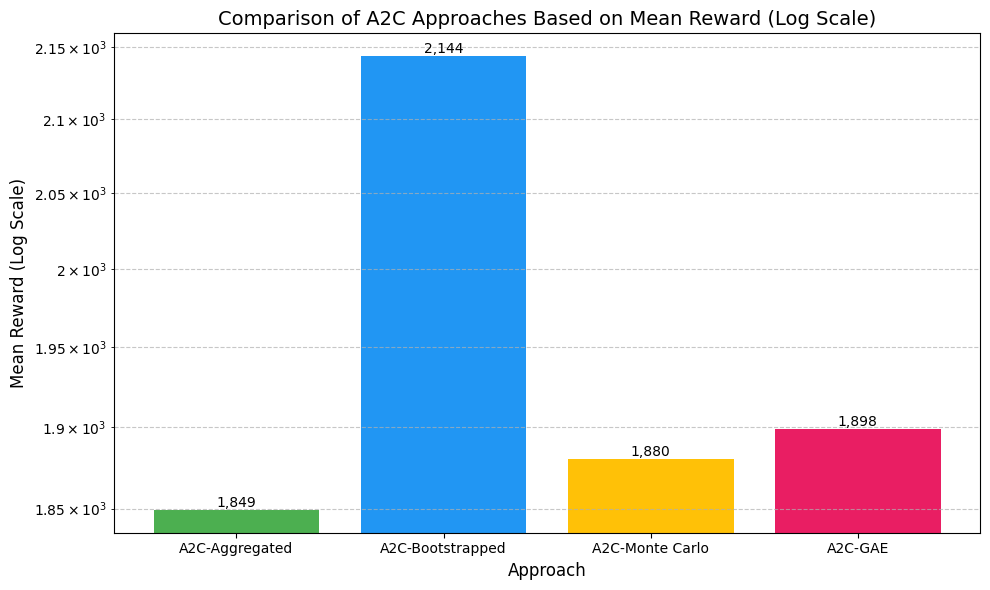

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the evaluation results
approaches = ['A2C-Aggregated', 'A2C-Bootstrapped', 'A2C-Monte Carlo', 'A2C-GAE']
mean_rewards = result_list

# Create the bar chart with log scale
plt.figure(figsize=(10, 6))
bars = plt.bar(approaches, mean_rewards, color=['#4CAF50', '#2196F3', '#FFC107', '#E91E63'])

# Apply logarithmic scale to the y-axis
plt.yscale('log')

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:,.0f}', ha='center', va='bottom', fontsize=10)

# Add titles and labels
plt.title('Comparison of A2C Approaches Based on Mean Reward (Log Scale)', fontsize=14)
plt.xlabel('Approach', fontsize=12)
plt.ylabel('Mean Reward (Log Scale)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7, which='both')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir ./tensorboard/

Reusing TensorBoard on port 6006 (pid 3092), started 0:02:57 ago. (Use '!kill 3092' to kill it.)

<IPython.core.display.Javascript object>